In [7]:
import pandas as pd
import numpy as np
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, mean_absolute_error, r2_score

pd.set_option('display.float_format', lambda x: '%.5f' % x)  #avoid displaying values in scientific notation

df = pd.read_parquet('final_cleaned_capstone_data.parquet')

#convert datetime to seconds for ease of modeling
df['program_current_premiere_date'] = pd.to_datetime(df['program_current_premiere_date']).astype('int64') // 10**9

print(df.shape)
df.head()

(3966, 29)


,Program,Partner - Episode Duration,Program - Broadcast Length,Exposures,Minutes Viewed,NO.of Scheduled Minutes,NO.of Telecasts,program_current_premiere_date,Month,Year,...,Program - Production Year,Program - Sub Category,Program - Supplier,Program Sub-Type,premiere_year,Series Type,Exposures_top25p_thrshld,Mins_vewd_top25p_thrshld,Exposures_success,Mins_vewd_success
0,american pickers_235262.0,3600.0,60.0,9.131449e+06,3.959216e+08,15616376,17,1641600,jun,2022,...,2020.0,artifactual & transactional,cineflix international media limited,unscripted,2022,legacy,2.712845e+06,1.121797e+08,1,1
1,american pickers: best of_268226.0,3600.0,60.0,1.264501e+06,5.539632e+07,5689563,2,1658534,jul,2023,...,2022.0,artifactual & transactional,stamford post production,unscripted,2022,legacy,2.712845e+06,1.121797e+08,0,0
2,barrett-jackson: revved up_287325.0,3600.0,60.0,6.600855e+04,2.699098e+06,204598,2,1693699,sep,2023,...,2023.0,gearhead,stamford post production,unscripted,2023,legacy,2.712845e+06,1.121797e+08,0,0
3,storage wars_265702.0,1800.0,30.0,1.451702e+06,3.071882e+07,2909038,8,1686614,jun,2023,...,2022.0,artifactual & transactional,"original productions, llc",unscripted,2023,legacy,2.712845e+06,1.121797e+08,0,0
4,the curse of oak island: digging deeper_283065.0,3600.0,60.0,1.785781e+06,8.044942e+07,119,2,1669680,nov,2022,...,2022.0,investigating history,stamford post production,docu-drama,2022,legacy,6.554475e+06,2.919624e+08,0,0


<Axes: >

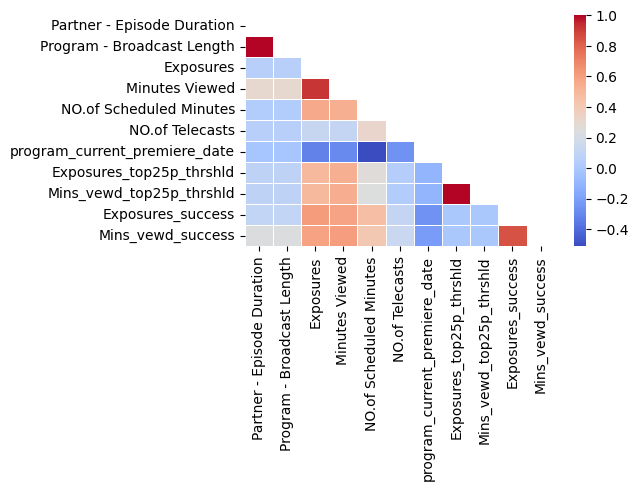

In [8]:
#make variable correlation visual
corrdata = df.select_dtypes(include='number')
corr = corrdata.corr()

plt.figure(figsize=(5, 3))
mask = np.triu(np.ones_like(corr, dtype=bool)) #mask for the upper triangle
sns.heatmap(corr, mask=mask, cmap='coolwarm', annot=False, fmt=".2f", linewidths=.5)

# Regressor approach

In [9]:
#Remove these cols:
# Program -- basically a unique ID field. could lead to overfitting
# Partner - Episode Duration -- same as Program - Broadcast length but comes from partner so possibly less complete
# Minutes viewed -- highly correlated with Exposures
# threshold columns -- because we created those columns in order to create success classification column. Not relevant. 
# success columns -- since this is a regressor approach

categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
numeric_columns = df.select_dtypes(exclude=['object']).columns.tolist()

#remove program name col because no point in making that a predictor variable
categorical_columns.remove('Program')

#remove these from numeric_columns b/c not relevant to analysis
numeric_columns = list(set(numeric_columns) - {'Partner - Episode Duration', 'Exposures_top25p_thrshld', 'Mins_vewd_top25p_thrshld', 'Mins_vewd_success', 'Minutes Viewed', 'Exposures_success'}) 

print('numeric_columns:', '\n', numeric_columns,'\n')
print('categorical_columns:', '\n', categorical_columns)

numeric_columns: 
 ['NO.of Scheduled Minutes', 'program_current_premiere_date', 'Exposures', 'NO.of Telecasts', 'Program - Broadcast Length'] 

categorical_columns: 
 ['Month', 'Year', 'Program - Network', 'Partner - Network', 'Partner - Name', 'Partner - Platform', 'Partner - Device', 'Program - Category', 'Program - Genre Name', 'Program - Mega Genre', 'Program - Network Name', 'Program - Production Year', 'Program - Sub Category', 'Program - Supplier', 'Program Sub-Type', 'premiere_year', 'Series Type']


In [10]:
# separate features & target
X = df[numeric_columns + categorical_columns] 
y = df['Exposures']

# split into train & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# preprocess numeric cols
numeric_transformer = make_pipeline( SimpleImputer(strategy='median'), StandardScaler() )

# preprocess categorical cols, make dummy cols using 1hot encoding 
categorical_transformer = make_pipeline( SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown='ignore') )

# combine preprocessing steps
preprocessor = make_column_transformer(
    (numeric_transformer, numeric_columns),
    (categorical_transformer, categorical_columns)
)

In [12]:
# make base models
models = [
    ('lr', LinearRegression()),
    ('lasso', Lasso()),
    ('ridge', Ridge()),
    ('elastic', ElasticNet()),
    ('rf', RandomForestRegressor()),
    ('gb', GradientBoostingRegressor()),
    ('xgb', XGBRegressor())
]

In [22]:
# make the voting regressor

ensemble = VotingRegressor(estimators=models, verbose=False) 
pipeline = make_pipeline(preprocessor, ensemble)
pipeline.fit(X_train, y_train) #fit to model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['NO.of Scheduled Minutes',
                                                   'program_current_premiere_date',
                                                   'Exposures',
                                                   'NO.of Telecasts',
                                                   'Program - Broadcast '
                                                   'Length']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer'...
                                                           grow_policy=None,
                                                           importance_type=None,
                                                           interaction_constraints=None,
                                                           learning_rate=None,
                                                           max_bin=None,
                                                           max_cat_threshold=None,
                                                           max_cat_to_onehot=None,
                                                           max_delta_step=None,
                                                           max_depth=None,
                                                           max_leaves=None,
                                                           min_child_weight=None,
                                                           missing=nan,
                                                           monotone_constraints=None,
                                                           multi_strategy=None,
                                                           n_estimators=None,
                                                           n_jobs=None,
                                                           num_parallel_tree=None,
                                                           random_state=None, ...))]))])

In [23]:
# evaluate the model
y_pred = pipeline.predict(X_test)

print("MSE: ", mean_squared_error(y_test, y_pred))
print("MAE: ", mean_absolute_error(y_test, y_pred))
print("R2: ", r2_score(y_test, y_pred))

MSE:  9409005081.461649
MAE:  64534.2207138965
R2:  0.997956862096785


In [24]:
xx = pd.DataFrame(y_pred).reset_index(drop='index')
yy = pd.DataFrame(y_test).reset_index(drop='index')

zz = pd.concat([ xx, yy ], axis=1)
zz

,0,Exposures
0,213150.81144,142285.99999
1,3852871.62351,3966157.37225
2,6264707.27504,6445183.44668
3,2860643.88568,2892666.24081
4,2160395.02032,2190037.54491
...,...,...
789,93442.07391,67984.88487
790,133622.98159,91600.54480
791,67693.56135,7052.12641
792,186393.09984,123111.33612


In [25]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.inspection import permutation_importance

# Cross-validation
cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
print("Cross-validation MSE: ", -cv_scores)
print("Mean MSE: ", -cv_scores.mean())
print("Standard deviation of MSE: ", cv_scores.std())

Cross-validation MSE:  [1.13963300e+10 1.19113198e+10 8.61828246e+09 1.27931049e+10
 1.09219920e+10]
Mean MSE:  11128205849.813011
Standard deviation of MSE:  1399949035.057904


In [26]:
# Feature importance
importances = permutation_importance(pipeline, X_test, y_test, n_repeats=10, random_state=42)
print("Feature importances:")
for feature, importance in zip(X.columns, importances.importances_mean):
    print(f"{feature}: {importance}")

Feature importances:
NO.of Scheduled Minutes: 0.0008973067684297731
program_current_premiere_date: 0.0001368146809579196
Exposures: 1.7930717013649162
NO.of Telecasts: 8.953710508086133e-06
Program - Broadcast Length: 1.2385904668243964e-05
Month: 3.521208188734803e-05
Year: 4.602873236070337e-05
Program - Network: 3.8099376884748184e-05
Partner - Network: 4.1156675843301296e-05
Partner - Name: 4.3443985549340706e-06
Partner - Platform: 2.1730289877208707e-05
Partner - Device: 2.3881806004433237e-06
Program - Category: 4.547771676818302e-05
Program - Genre Name: 8.631832309207166e-05
Program - Mega Genre: 8.822942156803127e-05
Program - Network Name: 3.6192861492145845e-05
Program - Production Year: 1.9505084007875872e-05
Program - Sub Category: 0.0001057323384341169
Program - Supplier: 0.00013451516598437241
Program Sub-Type: 1.1226829583077525e-05
premiere_year: 5.419831835307143e-06
Series Type: 4.37838993349815e-05


# Classifier approach 

In [ ]:
#Remove these cols:
# Program -- basically a unique ID field. could lead to overfitting
# Partner - Episode Duration -- same as Program - Broadcast length but comes from partner so possibly less complete
# Minutes viewed -- highly correlated with Exposures
# threshold columns -- because we created those columns in order to create success classification column. Not relevant. 
# Exposures -- since the dependant variable (Exposures_success was created from this

categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
numeric_columns = df.select_dtypes(exclude=['object']).columns.tolist()

#remove program name col because no point in making that a predictor variable
categorical_columns.remove('Program')

#remove these from numeric_columns b/c not relevant to analysis
numeric_columns = list(set(numeric_columns) - {'Partner - Episode Duration', 'Exposures_top25p_thrshld', 'Mins_vewd_top25p_thrshld', 'Mins_vewd_success', 'Minutes Viewed'}) 

print('numeric_columns:', '\n', numeric_columns,'\n')
print('categorical_columns:', '\n', categorical_columns)

In [ ]:
# separate features & target
X = df[numeric_columns + categorical_columns] 
y = df['Exposures_success']

# split into train & test sets: 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# preprocess numeric cols
numeric_transformer = make_pipeline( SimpleImputer(strategy='median'), StandardScaler() )

# preprocess categorical cols, make dummy cols using 1hot encoding 
categorical_transformer = make_pipeline( SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown='ignore') )

# combine preprocessing steps
preprocessor = make_column_transformer(
    (numeric_transformer, numeric_columns),
    (categorical_transformer, categorical_columns)
)

In [ ]:
# make base models
models = [
    ('lr', LogisticRegression()),
    ('dt', DecisionTreeClassifier()),
    ('rf', RandomForestClassifier()),
    ('gb', GradientBoostingClassifier()),
    ('xgb', XGBClassifier()),
    ('mlp', MLPClassifier()) #nerual network
]

differences between hard and soft voting in the VotingClassifier:

## Hard Voting
- Predicts the class label that gets the most votes from the individual classifiers
- Each base classifier votes for a class label, and the majority class is predicted
- Appropriate when the base models predict crisp class labels
- Example: If 3 classifiers predict labels [0, 0, 1], the ensemble predicts 0 since it has 2 votes vs 1 vote for class 1

## Soft Voting  
- Predicts the class label with the largest summed probability from the individual classifiers
- Each classifier predicts class probabilities, which are summed for each class, and the class with the highest sum is predicted
- Appropriate when the base models can predict class membership probabilities
- Example: If 3 classifiers predict probabilities [0.2, 0.8], [0.1, 0.9], [0.8, 0.2] for classes 0 and 1, the summed probabilities are 0.37 for class 0 and 0.63 for class 1, so class 1 is predicted

Soft voting is often considered the better option in ensemble learning for several reasons:

## Soft Voting best because

1. **More informative**: Soft voting uses probability estimates or confidence scores from each classifier, providing more nuanced information than hard voting, which only considers the final class labels
2. **Better handling of uncertainty**: By considering probabilities, soft voting can better account for the confidence levels of individual classifiers, potentially leading to more accurate predictions in cases where classifiers are uncertain
3. **Improved performance**: Soft voting often yields better results than hard voting, especially when the base models have varying levels of confidence or performance across different classes
4. **Finer decision-making**: In cases where classifiers disagree, soft voting can make more informed decisions by weighing the probabilities, rather than simply counting votes
5. **Diverse model strengths**: When ensemble models have different strengths and weaknesses across various classes or data subsets
6. **Close decisions**: In cases where the decision boundary is tight, the additional information from probabilities can be crucial

In [ ]:
# make the voting classifier

ensemble = VotingClassifier(estimators=models, voting='soft', verbose=True) 
pipeline = make_pipeline(preprocessor, ensemble) # make pipeline
pipeline.fit(X_train, y_train) # fit to model

In [ ]:
# evaluate model
y_pred = pipeline.predict(X_test)

print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred)) 
print("Recall: ", recall_score(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred))

In [ ]:
xx = pd.DataFrame(y_pred).reset_index(drop='index')
yy = pd.DataFrame(y_test).reset_index(drop='index')

zz = pd.concat([ xx, yy ], axis=1)

zz